In [1]:
import argparse
import pathlib
import random
from collections import deque
from typing import List, Dict, Tuple, Union
from data import Dataset
from data_utils import *
from models import BetaBernoulli
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sampling import *
%matplotlib inline  

import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

LOG_FREQ = 10
output_dir = pathlib.Path("../output/active_learning_difference")

In [2]:
dataset_name = 'cifar100'
metric = 'difference' # 'ece', 'confusion_matrix'
group_method = 'predicted_class'
pseudocount = 2
RUNS = 100
experiment_name = '%s_%s_groupby_%s_runs%d_pseudocount%.2f' % \
            (dataset_name, metric, group_method, RUNS, pseudocount)

dataset = Dataset.load_from_text(dataset_name)
dataset.group(group_method = group_method)
group0 = np.argmax(dataset.accuracy_k)
group1 = np.argmin(dataset.accuracy_k)

print(np.max(dataset.accuracy_k), np.min(dataset.accuracy_k))

0.9550561797752809 0.42857142857142855


In [3]:
def rope(alpha0, alpha1, beta0, beta1):
    num_samples = 10000
    theta_0 = np.random.beta(alpha0, beta0, size=(num_samples))
    theta_1 = np.random.beta(alpha1, beta1, size=(num_samples))
    delta = theta_0 - theta_1
    return [(delta < -0.05).mean(), (np.abs(delta) <= 0.05).mean(), (delta > 0.05).mean()]

def select_and_label(dataset: 'Dataset', sample_method: str, budget: int, prior=None, weighted=False) -> np.ndarray:
    
    if metric in ['accuracy', 'most_accurate', 'least_accurate', 'difference']:
        model = BetaBernoulli(dataset.num_groups, prior=prior, weight=dataset.weight_k)
        deques = dataset.enqueue()
        if metric == 'difference':
            for i in range(len(deques)):
                if i not in [group0, group1]:
                    deques[i].clear()
    else:
        return 

    sampled_indices = np.zeros((budget,), dtype=np.int) # indices of selected data points
    mpe_log = np.zeros((budget // LOG_FREQ, dataset.num_groups))
    rope_eval = np.zeros((budget // LOG_FREQ, 3))
    
    sample_fct = SAMPLE_CATEGORY[sample_method]

    idx = 0
    while idx < budget:
        if sample_method == 'ts':
            reward = model.reward(reward_type=metric, group0 = group0, group1 = group1)
            category = sample_fct(deques=deques, reward=reward)
        else:
            category = sample_fct(deques=deques, weighted=weighted)
        selected = deques[category].pop() # a dictionary
        model.update(category, selected)
        sampled_indices[idx] = selected['index']
        if (idx+1) % LOG_FREQ == 0:
            mpe_log[idx // LOG_FREQ] = model.mpe
            alpha0, beta0 = model._params[group0]
            alpha1, beta1 = model._params[group1]
            rope_eval[idx // LOG_FREQ] = rope(alpha0, alpha1, beta0, beta1)           
        idx += 1

    return {'sampled_indices': sampled_indices,  
            'mpe_log': mpe_log,
            'rope_eval': rope_eval}

In [4]:
def run():
    
    experiment_name = '%s_%s_groupby_%s_runs%d_pseudocount%.2f' % \
            (dataset_name, metric, group_method, RUNS, pseudocount)
    if not (output_dir / experiment_name).is_dir():
        (output_dir / experiment_name).mkdir()
    method_list = ['random_arm', 'random_data', 'ts_uniform', 'ts_informed']
    
    samples = {}
    mpe_log = {}
    rope_eval = {}
    dataset = Dataset.load_from_text(dataset_name)
    dataset.group(group_method = group_method)
    deques = dataset.enqueue()
    budget = len(deques[group0]) + len(deques[group1]) 
    
    UNIFORM_PRIOR = np.ones((dataset.num_groups, 2)) / 2 * pseudocount
    INFORMED_PRIOR = np.array([dataset.confidence_k, 1 - dataset.confidence_k]).T * pseudocount
    INFORMED_PRIOR[np.isnan(INFORMED_PRIOR)] = 1.0 / 2 * pseudocount
    config_dict = {
        'random_arm': [UNIFORM_PRIOR * 1e-6, 'random', False],
        'random_data': [UNIFORM_PRIOR * 1e-6, 'random', True],
        'ts_uniform': [UNIFORM_PRIOR, 'ts', None], 
        'ts_informed': [INFORMED_PRIOR, 'ts', None]}

    for method in method_list:
        samples[method] = np.zeros((RUNS, budget), dtype=np.int) 
        mpe_log[method] = np.zeros((RUNS, budget // LOG_FREQ, dataset.num_groups))
        rope_eval[method] = np.zeros((RUNS, budget // LOG_FREQ, 3))

    for r in tqdm(range(RUNS)):
        
        dataset = Dataset.load_from_text(dataset_name)
        dataset.group(group_method = group_method)
        dataset.shuffle(r)
        
        for method_name in method_list:
            prior, sample_method, weighted = config_dict[method_name]
            output = select_and_label(dataset, sample_method=sample_method, budget=budget, 
                                      prior=prior, weighted=weighted)  
            samples[method_name][r] = output['sampled_indices']
            mpe_log[method_name][r] = output['mpe_log']
            rope_eval[method_name][r] = output['rope_eval']
            
    # write samples to file
    for method in method_list:
        np.save(open(output_dir / experiment_name / ('samples_%s.npy' % method), 'wb'), samples[method])
        np.save(open(output_dir / experiment_name / ('mpe_log_%s.npy' % method), 'wb'), mpe_log[method])
        np.save(open(output_dir / experiment_name / ('rope_eval_%s.npy' % method), 'wb'), rope_eval[method])
    return samples, mpe_log, rope_eval

In [5]:
samples, mpe_log, rope_eval = run()

100%|██████████| 100/100 [06:53<00:00,  4.14s/it]


In [6]:
# samples = {}
# mpe_log = {}
# method_list = ['random_arm', 'random_data', 'ts_uniform', 'ts_informed']
# for method in method_list:
#     samples[method] = np.load(open(output / experiment_name / ('samples_%s.npy' % method), 'rb'))
#     mpe_log[method] = np.load(open(output / experiment_name / ('mpe_log_%s.npy' % method), 'rb'))

0.9550561797752809 0.42857142857142855


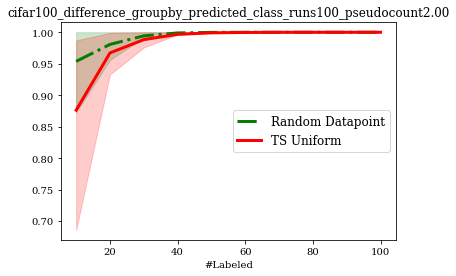

In [12]:
dataset = Dataset.load_from_text(dataset_name)
dataset.group(group_method = group_method)
deques = dataset.enqueue()
start = 0
budget = len(deques[group0]) + len(deques[group1]) 
num_steps = budget // LOG_FREQ // 2
stepsize = 1
rope_region = 2

method_format = {#'random_arm': ('Random Arm', 'b', '.', '-.'), 
                 'random_data': ('Random Datapoint', 'g', '^', '-.'), 
                 'ts_uniform': ('TS Uniform', 'r', '*', '-'), 
                 #'ts_informed': ('TS Informed', 'r', '+', '-.'),
                }

plt.figure(figsize=(6,4))
print(dataset.accuracy_k[group0], dataset.accuracy_k[group1])

for method_name in method_format:  

    legend_name, color, marker, linestyle = method_format[method_name]
    
    xrange = np.arange(num_steps) * LOG_FREQ + LOG_FREQ
    mean_error = np.mean(rope_eval[method_name][:,:, rope_region], axis=0)
    lb_error = np.quantile(rope_eval[method_name][:,:, rope_region], 0.125, axis=0)
    ub_error = np.quantile(rope_eval[method_name][:,:, rope_region], 0.875, axis=0)

    idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]   
    plt.plot(xrange[idx], 
             mean_error[idx], 
             label=legend_name, linewidth=3, color=color, linestyle=linestyle)
    plt.fill_between(xrange[idx], 
                     lb_error[idx], 
                     ub_error[idx], 
                     color=color, alpha=.2)
    #plt.ylim([0, 0.3])
    plt.xlabel('#Labeled')
#     plt.ylabel('$L_2$ Error')
    #plt.xscale('log')
    plt.legend(fontsize=12, loc='center right')
    plt.title(experiment_name)

In [8]:
len(deques[group0]),len(deques[group1])

(89, 119)